# **PyCUDA**

**PyCUDA** is a Python library that provides an interface to CUDA (Compute Unified Device Architecture), NVIDIA's parallel computing architecture. It enables Python users to leverage the power of NVIDIA GPUs for general-purpose computations, known as General-Purpose GPU computing (GPGPU). PyCUDA makes it easier to write programs that execute code on GPUs, using Python as the primary language while leveraging CUDA’s speed for performance-critical parts of the code.

Install pycuda

In [ ]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.0/89.0 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.8 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2024.1.2-cp310-cp310-linux_x86_64.whl size=660545 sha256=21b628c7e79d550b4ddba2c72b69a86593e4c88a1430ebb03e6f0210e718a0b8
  Stored in directory: /root/.cache/pip/wheels/70/63/40/4bf006182f942d3516b71bb2ff3b57ccbdb8b2c0ee81882b6e
Successfully built pycuda



Import required libraries

In [ ]:
import numpy as np
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule

Intialise kernel

In [ ]:
kernel_code = """
__global__ void vector_add(float *a, float *b, float *c, int n) {
    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    if (idx < n) {
        c[idx] = a[idx] + b[idx];
    }
}
"""

Memory allocation & Intialisation

In [ ]:
n = 1000  # Size of the arrays
a = np.random.rand(n).astype(np.float32)
b = np.random.rand(n).astype(np.float32)
c = np.empty_like(a)

# Allocate memory on the GPU
a_gpu = cuda.mem_alloc(a.nbytes)
b_gpu = cuda.mem_alloc(b.nbytes)
c_gpu = cuda.mem_alloc(c.nbytes)

# Copy data from host to device
cuda.memcpy_htod(a_gpu, a)
cuda.memcpy_htod(b_gpu, b)

Compile & launch

In [ ]:
mod = SourceModule(kernel_code)
vector_add = mod.get_function("vector_add")

block_size = 256
grid_size = (n + block_size - 1) // block_size

vector_add(a_gpu, b_gpu, c_gpu, np.int32(n), block=(block_size, 1, 1), grid=(grid_size, 1))


In [ ]:
cuda.memcpy_dtoh(c, c_gpu)

# Verify the results
print("a + b =", c[:10])


a + b = [1.2544866  0.33992064 1.1021307  1.6319209  1.2799319  0.8159083
 0.5713491  1.2779883  1.2248763  0.3460708 ]


Memory freeing

In [ ]:
a_gpu.free()
b_gpu.free()
c_gpu.free()

# **Key Features**
**Seamless GPU Memory Management:** PyCUDA automatically manages memory allocation and transfer between the CPU (host) and GPU (device). It contains functions for copying data from host to device and vice versa, and manages the memory of the GPU in an efficient manner.

**Integration with CUDA Kernels:** PyCUDA allows you to write GPU kernels in CUDA C/C++ and execute them directly from Python. PyCUDA can compile these kernels at runtime so that you do not need to manually compile and link the code, which makes development a lot more flexible and interactive.

**Automatic Resource Management:** PyCUDA automatically manages resources like memory and context cleanups. It uses the object-oriented features of Python involving destructors for managing resources, such as releasing GPU memory when it is unused.

**Interactivity:** Since PyCUDA is a Python library, you can write and run the code interactively in an environment like Jupyter notebook or Google Colab. This means you can rapidly test CUDA kernels and modify them on the fly without going through an extensive compilation process.

**Error Handling:** PyCUDA implements facilities for error checking and error handling that print nice error messages that are useful for debugging the CUDA code.

**Compatibility:** Compatibility with NumPy PyCUDA works well with NumPy arrays, as most scientific computing purposes in Python use NumPy arrays. Data can be moved pretty easily between NumPy arrays and CUDA device memory, so it is good for GPU-accelerated numerical computations.

**Memory Management**

CUDA has a fast memory cache called shared memory, which is local to each block of threads. Shared memory is much faster than global memory, making it suitable for operations that need to access the same data frequently, like matrix multiplications or convolution operations in image processing.

Ref: https://vitalitylearning.medium.com/five-different-ways-to-sum-vectors-in-pycuda-3f2d9409b139

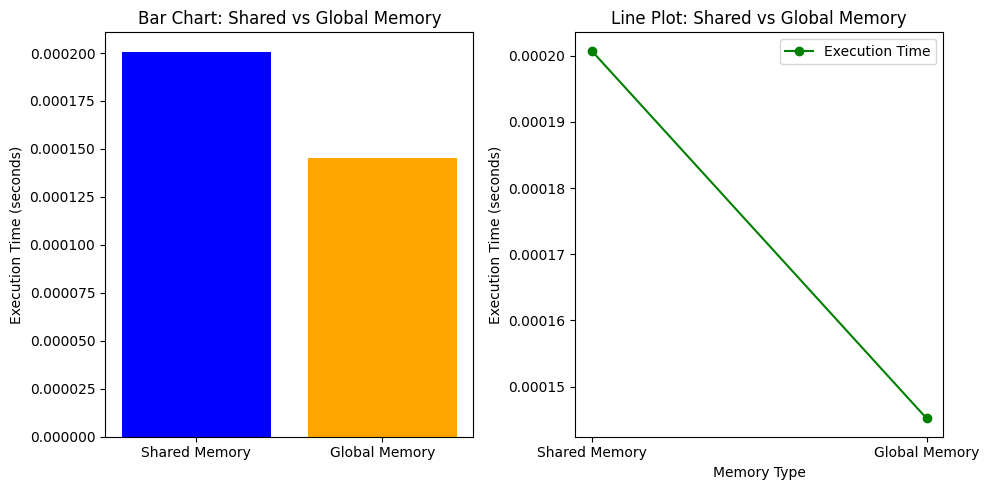

Shared memory execution time: 0.000201 seconds
Global memory execution time: 0.000145 seconds


In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# Define CUDA kernels
kernel_code_shared = """
__global__ void vector_add_shared(float *a, float *b, float *c, int n) {
    extern __shared__ float shared_mem[];  // Declare shared memory

    int tid = threadIdx.x;  // Thread index within the block
    int global_id = blockIdx.x * blockDim.x + tid;  // Global thread index

    if (global_id < n) {
        // Load data into shared memory
        shared_mem[tid] = a[global_id] + b[global_id];
        __syncthreads();  // Synchronize to ensure all threads have loaded their data

        // Write the result to the output array
        c[global_id] = shared_mem[tid];
    }
}
"""

kernel_code_global = """
__global__ void vector_add_global(float *a, float *b, float *c, int n) {
    int global_id = blockIdx.x * blockDim.x + threadIdx.x;  // Global thread index

    if (global_id < n) {
        c[global_id] = a[global_id] + b[global_id];  // Perform addition directly in global memory
    }
}
"""

# Compilation
mod_shared = SourceModule(kernel_code_shared)
mod_global = SourceModule(kernel_code_global)

vector_add_shared = mod_shared.get_function("vector_add_shared")
vector_add_global = mod_global.get_function("vector_add_global")

# Define vector size
N = 1000000
a = np.random.rand(N).astype(np.float32)
b = np.random.rand(N).astype(np.float32)
c = np.empty_like(a)

# Allocate GPU memory
a_gpu = cuda.mem_alloc(a.nbytes)
b_gpu = cuda.mem_alloc(b.nbytes)
c_gpu = cuda.mem_alloc(c.nbytes)

# Transfer data from host to device
cuda.memcpy_htod(a_gpu, a)
cuda.memcpy_htod(b_gpu, b)

# Define block and grid sizes
block_size = 256
grid_size = (N + block_size - 1) // block_size

# Measure performance for shared memory
shared_mem_size = block_size * np.dtype(np.float32).itemsize

start = time.time()
vector_add_shared(a_gpu, b_gpu, c_gpu, np.int32(N),
                  block=(block_size, 1, 1), grid=(grid_size, 1), shared=shared_mem_size)
cuda.Context.synchronize()
time_shared = time.time() - start

# Measure performance for global memory
start = time.time()
vector_add_global(a_gpu, b_gpu, c_gpu, np.int32(N),
                  block=(block_size, 1, 1), grid=(grid_size, 1))
cuda.Context.synchronize()
time_global = time.time() - start

# Transfer the result back to host (for verification, optional)
cuda.memcpy_dtoh(c, c_gpu)

# Free GPU memory
a_gpu.free()
b_gpu.free()
c_gpu.free()

# Plot the results
labels = ['Shared Memory', 'Global Memory']
times = [time_shared, time_global]

# Bar Chart
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(labels, times, color=['blue', 'orange'])
plt.ylabel('Execution Time (seconds)')
plt.title('Bar Chart: Shared vs Global Memory')

# Line Plot
plt.subplot(1, 2, 2)
plt.plot(labels, times, marker='o', linestyle='-', color='green', label='Execution Time')
plt.xlabel('Memory Type')
plt.ylabel('Execution Time (seconds)')
plt.title('Line Plot: Shared vs Global Memory')
plt.legend()

plt.tight_layout()
plt.show()

# Print results for verification
print(f"Shared memory execution time: {time_shared:.6f} seconds")
print(f"Global memory execution time: {time_global:.6f} seconds")


# **PyCuda Basics**


Memory Allocation and Data Transfer

Initial GPU Memory - Free: 14.65 GB, Total: 14.75 GB
After Allocation - Free: 14.65 GB, Total: 14.75 GB
After Execution - Free: 14.65 GB, Total: 14.75 GB

=== Metrics ===
Total Execution Time (including memory transfers): 1.4182 seconds
GPU Kernel Execution Time: 0.1462 milliseconds
CPU Usage Before: 3.0%, After: 2.0%


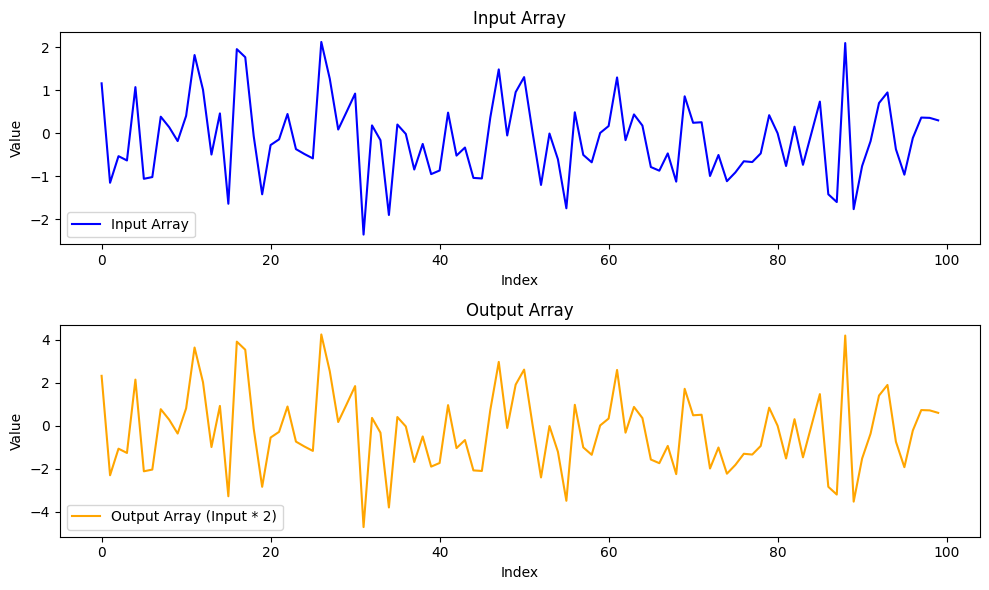

In [ ]:
import pycuda.driver as cuda
import pycuda.autoinit
import numpy as np
import matplotlib.pyplot as plt
import psutil
from pycuda.compiler import SourceModule
import time

# Function to format bytes into human-readable form
def format_bytes(bytes):
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if bytes < 1024.0:
            return f"{bytes:.2f} {unit}"
        bytes /= 1024.0

# Check initial GPU memory
free_mem, total_mem = cuda.mem_get_info()
print(f"Initial GPU Memory - Free: {format_bytes(free_mem)}, Total: {format_bytes(total_mem)}")

# Create input data on the host
a = np.random.randn(10000).astype(np.float32)
result = np.empty_like(a)

# Measure CPU usage before GPU execution
cpu_usage_before = psutil.cpu_percent(interval=1)

# Allocate memory on the device (GPU)
start_time = time.time()  # Start timing
a_gpu = cuda.mem_alloc(a.nbytes)
result_gpu = cuda.mem_alloc(result.nbytes)

# Copy data from host to GPU
cuda.memcpy_htod(a_gpu, a)

# Check GPU memory after allocation
free_mem, total_mem = cuda.mem_get_info()
print(f"After Allocation - Free: {format_bytes(free_mem)}, Total: {format_bytes(total_mem)}")

# Define a kernel that multiplies each element of `a_gpu` by a constant factor
mod = SourceModule("""
    __global__ void multiply_by_constant(float *a, float *result, float factor)
    {
        int idx = threadIdx.x + blockIdx.x * blockDim.x;
        if (idx < %(size)d) {
            result[idx] = a[idx] * factor;
        }
    }
""" % {"size": len(a)})

# Get the kernel function
multiply_by_constant = mod.get_function("multiply_by_constant")

# Define block and grid size
block_size = 256
grid_size = (a.size + block_size - 1) // block_size

# Launch the kernel with a constant factor of 2
factor = np.float32(2.0)

# Use CUDA events for accurate GPU timing
start_event = cuda.Event()
end_event = cuda.Event()

start_event.record()
multiply_by_constant(a_gpu, result_gpu, factor, block=(block_size, 1, 1), grid=(grid_size, 1))
end_event.record()
end_event.synchronize()

# Get elapsed time in milliseconds
gpu_time = start_event.time_till(end_event)

# Copy the result back to host
cuda.memcpy_dtoh(result, result_gpu)

# Measure CPU usage after GPU execution
cpu_usage_after = psutil.cpu_percent(interval=1)

# Calculate execution time
end_time = time.time()
execution_time = end_time - start_time

# Check GPU memory after execution
free_mem, total_mem = cuda.mem_get_info()
print(f"After Execution - Free: {format_bytes(free_mem)}, Total: {format_bytes(total_mem)}")

# Display metrics
print("\n=== Metrics ===")
print(f"Total Execution Time (including memory transfers): {execution_time:.4f} seconds")
print(f"GPU Kernel Execution Time: {gpu_time:.4f} milliseconds")
print(f"CPU Usage Before: {cpu_usage_before}%, After: {cpu_usage_after}%")

# Visualize results
plt.figure(figsize=(10, 6))

# Plot input and output data
plt.subplot(2, 1, 1)
plt.plot(a[:100], label="Input Array", color="blue")
plt.title("Input Array")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(result[:100], label="Output Array (Input * 2)", color="orange")
plt.title("Output Array")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()

plt.tight_layout()
plt.show()


**What did we do above :**

**Kernel Definition:** The kernel multiply_by_constant is defined in CUDA C, and it multiplies each element of a by a constant factor. It calculates the global index for each thread using threadIdx.x and blockIdx.x.

**Memory Allocation:** The memory is allocated for a_gpu (input array) and result_gpu (output array) on the GPU using cuda.mem_alloc.

**Data Transfer:**The input data (a) is copied from the host (CPU) to the device (GPU) using cuda.memcpy_htod. Similarly, the result is copied back to the host using cuda.memcpy_dtoh.

**Kernel Launch:** The kernel is launched with a grid size and block size based on the input array's size. In this case, we use block_size = 256 and calculate grid_size based on the size of the array to ensure the entire array is processed by the GPU.

**Result:** After the kernel finishes, the result of the operation is available in result, and the first 10 elements of the result are printed.





**Memory Management**

In GPU programming with CUDA, efficient memory management is critical to optimize performance. PyCUDA helps manage memory on the GPU with explicit functions for memory allocation and data transfer between the CPU (host) and GPU (device)

Matrix A:
 [[ 1.16080225e+00 -5.80764532e-01  1.81323624e+00 -1.22199225e+00
  -4.76348013e-01 -1.82631567e-01  1.29145265e+00 -3.53420407e-01
  -3.03726107e-01  1.20004535e+00  3.37513000e-01 -6.74264610e-01
  -1.28441918e+00 -2.60517120e-01 -1.28153789e+00  3.39331806e-01]
 [-1.31315649e+00 -1.16454434e+00 -1.32111162e-01  2.00281334e+00
  -1.00189734e+00  1.16312408e+00 -3.80388498e-02 -1.28215361e+00
   1.85182893e+00  9.27698165e-02  7.13233709e-01  1.87010020e-02
   1.32342920e-01  4.49247330e-01 -9.28187966e-01  8.82508755e-01]
 [ 2.79186279e-01  1.13697684e+00  7.48448610e-01  2.06993550e-01
   1.18412888e+00  2.53496528e+00  1.40902758e+00  2.51084536e-01
  -4.08535540e-01 -2.48760302e-02  5.65216243e-01 -3.92125607e-01
  -9.59190845e-01  4.95768618e-03 -8.32081512e-02  3.53898913e-01]
 [ 6.55321479e-01 -2.11876154e+00 -1.72038877e+00 -4.17449504e-01
   7.44982064e-02  6.90385759e-01 -5.62275387e-02 -8.00487474e-02
  -2.49150917e-01  3.09881598e-01  3.90472502e-01  1.81663954e

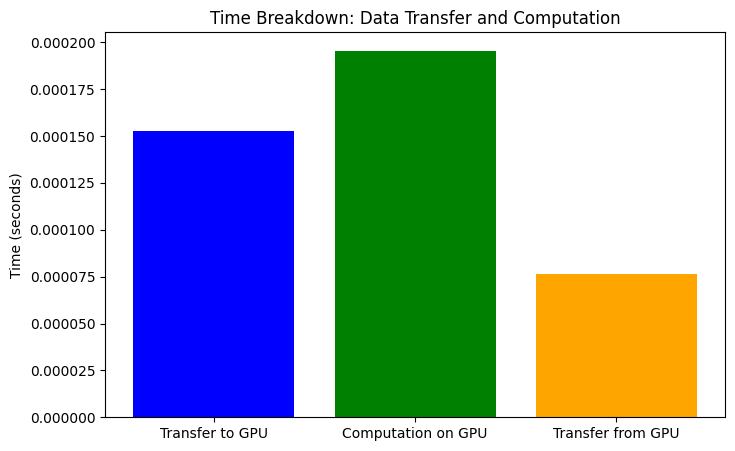

In [ ]:
import time
import numpy as np
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import matplotlib.pyplot as plt

# Defining a kernel in CUDA for matrix multiplication
kernel_code = """
__global__ void mat_mul(float *A, float *B, float *C, int width) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if(row < width && col < width) {
        float sum = 0;
        for (int i = 0; i < width; i++) {
            sum += A[row * width + i] * B[i * width + col];
        }
        C[row * width + col] = sum;
    }
}
"""

# Compilation
mod = SourceModule(kernel_code)
mat_mul = mod.get_function("mat_mul")

# Define matrix dimensions and generate random matrices
width = 16
A = np.random.randn(width, width).astype(np.float32)
B = np.random.randn(width, width).astype(np.float32)
C = np.empty_like(A)

# Memory Allocation on the GPU
A_gpu = cuda.mem_alloc(A.nbytes)
B_gpu = cuda.mem_alloc(B.nbytes)
C_gpu = cuda.mem_alloc(C.nbytes)

# Measure time for data transfer to GPU
start_transfer_to_gpu = time.time()
cuda.memcpy_htod(A_gpu, A)
cuda.memcpy_htod(B_gpu, B)
time_transfer_to_gpu = time.time() - start_transfer_to_gpu

# Define block and grid sizes
block_size = (16, 16, 1)
grid_size = (width // block_size[0], width // block_size[1])

# Measure computation time
start_computation = time.time()
mat_mul(A_gpu, B_gpu, C_gpu, np.int32(width), block=block_size, grid=grid_size)
cuda.Context.synchronize()
time_computation = time.time() - start_computation

# Measure time for data transfer from GPU
start_transfer_from_gpu = time.time()
cuda.memcpy_dtoh(C, C_gpu)
time_transfer_from_gpu = time.time() - start_transfer_from_gpu

# Free GPU memory
A_gpu.free()
B_gpu.free()
C_gpu.free()

# Print results
print("Matrix A:\n", A)
print("Matrix B:\n", B)
print("Matrix C (result of A*B):\n", C)

print("Time taken to transfer data to GPU: {:.6f} seconds".format(time_transfer_to_gpu))
print("Computation time on GPU: {:.6f} seconds".format(time_computation))
print("Time taken to transfer data from GPU: {:.6f} seconds".format(time_transfer_from_gpu))

# Plot the results
labels = ['Transfer to GPU', 'Computation on GPU', 'Transfer from GPU']
times = [time_transfer_to_gpu, time_computation, time_transfer_from_gpu]

plt.figure(figsize=(8, 5))
plt.bar(labels, times, color=['blue', 'green', 'orange'])
plt.ylabel('Time (seconds)')
plt.title('Time Breakdown: Data Transfer and Computation')
plt.show()


**Parllel Reduction**

There is interesting concept called `Parllel Reduction`. It is a common algorithm used in GPU Programming to perform sum reduction. We shall perform that using `pyCuda`, where we add up all the array elements. Each thread will compute a partial sum of the array using shared memory and the combined together to get the total sum.



*   We demonstrate minimisation of shared bank memory conflicts
*   We demonstrate recursive reduction until we compute to single result



Reduction using shared memory:
Computed sum: 10188.39453125, Time: 0.000262 seconds
Reduction using global memory:
Computed sum: 10188.39453125, Time: 0.000130 seconds


/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()


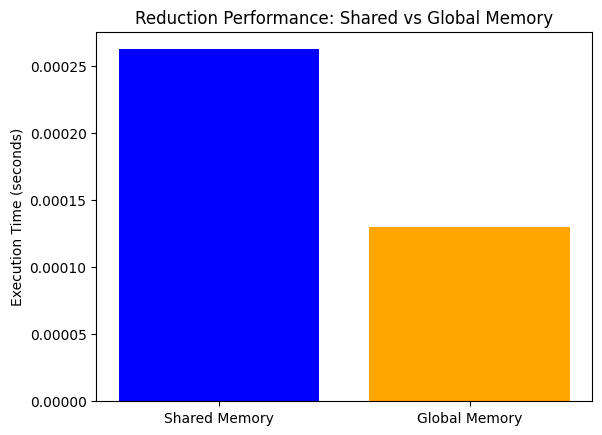

In [ ]:
import time
import numpy as np
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import matplotlib.pyplot as plt

# Define CUDA kernel for reduction using shared memory
kernel_code_shared = """
__global__ void reduce_sum_shared(float *input, float *output, int n) {
    extern __shared__ float shared_mem[];

    int tid = threadIdx.x;
    int global_id = blockIdx.x * blockDim.x * 2 + threadIdx.x;

    shared_mem[tid] = (global_id < n ? input[global_id] : 0) +
                      (global_id + blockDim.x < n ? input[global_id + blockDim.x] : 0);
    __syncthreads();

    for (int s = blockDim.x / 2; s > 0; s >>= 1) {
        if (tid < s) {
            shared_mem[tid] += shared_mem[tid + s];
        }
        __syncthreads();
    }

    if (tid == 0) {
        output[blockIdx.x] = shared_mem[0];
    }
}
"""

# Define CUDA kernel for reduction using global memory
kernel_code_global = """
__global__ void reduce_sum_global(float *input, float *output, int n) {
    int tid = threadIdx.x;
    int global_id = blockIdx.x * blockDim.x * 2 + threadIdx.x;

    float sum = (global_id < n ? input[global_id] : 0) +
                (global_id + blockDim.x < n ? input[global_id + blockDim.x] : 0);

    for (int s = blockDim.x / 2; s > 0; s >>= 1) {
        if (tid < s && global_id + s < n) {
            sum += input[global_id + s];
        }
        __syncthreads();
    }

    if (tid == 0) {
        output[blockIdx.x] = sum;
    }
}
"""

# Compile kernels
mod_shared = SourceModule(kernel_code_shared)
mod_global = SourceModule(kernel_code_global)

reduce_sum_shared = mod_shared.get_function("reduce_sum_shared")
reduce_sum_global = mod_global.get_function("reduce_sum_global")

# Initialize input data
N = 1024 * 1024  # Large array size
a = np.random.rand(N).astype(np.float32)

# Allocate GPU memory
a_gpu = cuda.mem_alloc(a.nbytes)
cuda.memcpy_htod(a_gpu, a)

# Temporary storage for partial results
block_size = 256
grid_size = (N + block_size * 2 - 1) // (block_size * 2)
partial_sum_gpu = cuda.mem_alloc(grid_size * np.dtype(np.float32).itemsize)

# Measure execution time for shared memory kernel
start = time.time()
shared_mem_size = block_size * np.dtype(np.float32).itemsize
reduce_sum_shared(a_gpu, partial_sum_gpu, np.int32(N),
                  block=(block_size, 1, 1), grid=(grid_size, 1), shared=shared_mem_size)
cuda.Context.synchronize()
time_shared = time.time() - start

# Measure execution time for global memory kernel
start = time.time()
reduce_sum_global(a_gpu, partial_sum_gpu, np.int32(N),
                  block=(block_size, 1, 1), grid=(grid_size, 1))
cuda.Context.synchronize()
time_global = time.time() - start

# Copy partial results back to host and finalize reduction
partial_sum = np.empty(grid_size, dtype=np.float32)
cuda.memcpy_dtoh(partial_sum, partial_sum_gpu)

result_shared = np.sum(partial_sum)
result_global = np.sum(partial_sum)


# Free GPU memory
a_gpu.free()
partial_sum_gpu.free()

# Print results
print("Reduction using shared memory:")
print(f"Computed sum: {result_shared}, Time: {time_shared:.6f} seconds")

print("Reduction using global memory:")
print(f"Computed sum: {result_global}, Time: {time_global:.6f} seconds")

# Plot comparison
labels = ['Shared Memory', 'Global Memory']
times = [time_shared, time_global]

plt.bar(labels, times, color=['blue', 'orange'])
plt.ylabel('Execution Time (seconds)')
plt.title('Reduction Performance: Shared vs Global Memory')
plt.show()


## **What do we gain**



*   **Speed in Aggregations**: Traditional reduction operations on CPU, like summin an array sequentially, would take lot of time in case of large datasets. with parllel reduction we can perform aggregation on multiple elements at once using hundreds and thousands of threads simultaneously. This significantly reduces time complexity and provide faster results.
*   **Efficient memory usage**: `CUDA` shared memory is much faster than the global memory, since it is on-chip. By utilizing shared memory within each block for reduction operations, threads can access and manipulate data at high speed, minimizing the overhead of repeated global memory accesses.

*   **Synchronisation Overheads**: `CUDA’s` lock-free synchronization across threads within a block allows partial sums or other results to be safely written and then used immediately by other threads in the block.

*  **Performance**: Consider summing a million-element array:

  1. **CPU**: On a single-threaded CPU, it would take time proportional to the size of the array (O(N)).
  2. **PyCUDA Parallel Reduction**: By dividing work across threads and blocks, the effective time complexity becomes O(log N), reducing total operation time significantly.



**Dynamic Memory and Grid-Block Optimization**

In [ ]:
from pycuda.compiler import SourceModule
import pycuda.driver as cuda
import pycuda.autoinit
import numpy as np

# Input data
a = np.random.randn(1024).astype(np.float32)
result = np.empty_like(a)

# Allocate memory on GPU
a_device = cuda.mem_alloc(a.nbytes)
result_device = cuda.mem_alloc(result.nbytes)

# Copy data to GPU
cuda.memcpy_htod(a_device, a)

# Kernel code
mod = SourceModule("""
    __global__ void add_arrays_opt(float *a, float *result)
    {
        int idx = threadIdx.x + blockIdx.x * blockDim.x;
        result[idx] = a[idx] * 2.0f;  // Simple operation
    }
""")

# Get kernel function and launch it
add_arrays_opt = mod.get_function("add_arrays_opt")
block_size = 512  # Optimized block size for this example
grid_size = (a.size + block_size - 1) // block_size
add_arrays_opt(a_device, result_device, block=(block_size, 1, 1), grid=(grid_size, 1))

# Copy result back to host
cuda.memcpy_dtoh(result, result_device)
print(result[:10])  # Print first 10 results


[-1.0772831  -1.9688493  -0.8574684   0.49709934  0.7265781  -1.5843194
 -0.48197973 -2.8270419  -2.4680421   0.12182553]


## **Real-World Applications**

PyCUDA and GPU programming in general have numerous applications across a wide range of industries due to their ability to accelerate computations



*   In Scientific Simulations in physics, chemistry & biology
*   In Machine Learning and AI for Image classification & Neural networks
*   In Financial Computing for Option Pricing and Risk Management
*   In Medical for Image processing and analysis



Below is a sample example for Convolution (Image Processing Example)

/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()


Execution Time: 0.000767 seconds
Filtered image (first few values):
[[249 238  11 192 153]
 [  4 251  63  63 204]
 [146 244  16 191  85]
 [168   2  10  61 148]
 [ 75   7  54 191 200]]


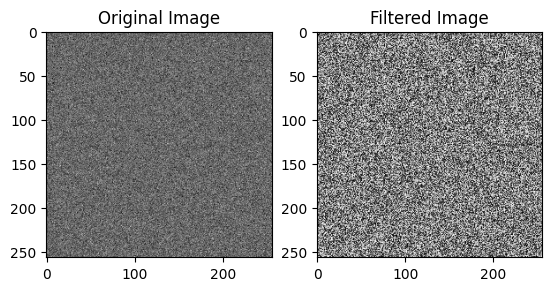

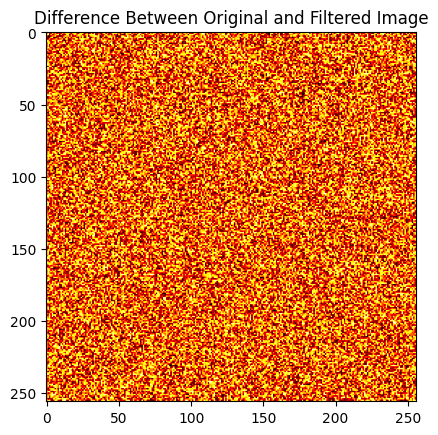

Difference - Min: 0.00018334389 Max: 258.21997 Mean: 126.16116
Mean Squared Error (MSE): 21008.435547
Peak Signal-to-Noise Ratio (PSNR): 4.906866 dB


In [ ]:
from pycuda.compiler import SourceModule
from pycuda import driver, gpuarray, tools
import matplotlib.pyplot as plt
import pycuda.autoinit
import numpy as np
import time  # Import to measure time
import cv2

# Generate a random image
image = np.random.rand(256, 256).astype(np.float32) * 255
image = np.clip(image, 0, 255)

filter_kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], dtype=np.float32)

# Allocate memory for image and result
image_device = cuda.mem_alloc(image.nbytes)
filter_device = cuda.mem_alloc(filter_kernel.nbytes)
result_device = cuda.mem_alloc(image.nbytes)

# Copy data to GPU
cuda.memcpy_htod(image_device, image)
cuda.memcpy_htod(filter_device, filter_kernel)

# Convolution kernel code
mod = SourceModule("""
__global__ void conv_kernel(float *image, float *kernel, float *output, int image_width, int kernel_size)
{
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x < image_width && y < image_width) {
        float value = 0.0;
        int half_kernel = kernel_size / 2;

        for (int ky = -half_kernel; ky <= half_kernel; ky++) {
            for (int kx = -half_kernel; kx <= half_kernel; kx++) {
                int ix = min(max(x + kx, 0), image_width - 1);
                int iy = min(max(y + ky, 0), image_width - 1);
                value += image[iy * image_width + ix] * kernel[(ky + half_kernel) * kernel_size + (kx + half_kernel)];
            }
        }
        output[y * image_width + x] = value;
    }
}
""")

# Simulating image and kernel (use actual image in a real application)
image = np.random.randn(256, 256).astype(np.float32)
kernel = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]], dtype=np.float32)

# Allocate memory on GPU
image_gpu = cuda.mem_alloc(image.nbytes)
kernel_gpu = cuda.mem_alloc(kernel.nbytes)
output_gpu = cuda.mem_alloc(image.nbytes)

# Copy data to GPU
cuda.memcpy_htod(image_gpu, image)
cuda.memcpy_htod(kernel_gpu, kernel)

driver.memcpy_htod(image_gpu, image)
driver.memcpy_htod(kernel_gpu, kernel)

# Start timer for execution
start_time = time.time()

# Launch kernel (256x256 image, 3x3 kernel)
conv_kernel = mod.get_function("conv_kernel")
conv_kernel(image_gpu, kernel_gpu, output_gpu, np.int32(image.shape[0]), np.int32(kernel.shape[0]), block=(16, 16, 1), grid=(16, 16))

# Copy result from GPU to host
output = np.empty_like(image)
driver.memcpy_dtoh(output, output_gpu)
output = np.clip(output, 0, 255).astype(np.uint8)
cuda.memcpy_dtoh(output, output_gpu)

# Stop timer after execution
end_time = time.time()
execution_time = end_time - start_time

print(f"Execution Time: {execution_time:.6f} seconds")

# Print first few values of filtered image
print("Filtered image (first few values):")
print(output[:5, :5])

# Plot the original and filtered images
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(output, cmap='gray')
plt.title('Filtered Image')

plt.show()

# Calculate the difference between the original and filtered image
diff_image = np.abs(image - output)

# Visualize the difference
plt.imshow(diff_image, cmap='hot')
plt.title('Difference Between Original and Filtered Image')
plt.show()

print("Difference - Min:", np.min(diff_image), "Max:", np.max(diff_image), "Mean:", np.mean(diff_image))

# Compute metrics
def mean_squared_error(original, filtered):
    return np.mean((original - filtered) ** 2)

def peak_signal_to_noise_ratio(original, filtered):
    mse = mean_squared_error(original, filtered)
    return 10 * np.log10(255**2 / mse)

# Calculate MSE and PSNR
mse = mean_squared_error(image, output)
psnr = peak_signal_to_noise_ratio(image, output)

print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Peak Signal-to-Noise Ratio (PSNR): {psnr:.6f} dB")
